In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
path = 'Data/SIR_Origin/*.csv'
dic_files = Load_files.load_files(path, -17, -15)
data = dic_files['서울']
data

,Date,City,Susceptible,Infected,Dead,Recovered,alpha,beta,gamma
0,2020-01-20,서울,9535432,0,0,0,0.000000,0.000000,0.000000
1,2020-01-21,서울,9535432,0,0,0,0.000000,0.000000,0.000000
2,2020-01-22,서울,9535432,0,0,0,0.000000,0.000000,0.000000
3,2020-01-23,서울,9535432,0,0,0,0.000000,0.000000,0.000000
4,2020-01-24,서울,9535431,1,0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1214,2023-05-20,서울,3372946,63591,6471,6092424,0.186540,0.169175,0.000031
1215,2023-05-21,서울,3368750,57027,6473,6103182,0.063087,0.028793,0.000053
1216,2023-05-22,서울,3367479,56653,6476,6104824,0.268003,0.101407,0.000018
1217,2023-05-23,서울,3362117,56269,6477,6110569,0.267742,0.099895,0.000036


In [3]:
learning_rates_list = [1e-3, 1e-4, 1e-5]
patiences_list = [20, 50, 100]
num_layers_list = [2, 4, 8]
batch_sizes_list = [16, 32, 64]
hidden_sizes_list = [8, 16, 32]
dropout_list = [0.25, 0.5]

hyperparameter_dict = {}
i = 0

for lr in learning_rates_list:
    for patience in patiences_list:
        for num_layers in num_layers_list:
            for batch_sizes in batch_sizes_list:
                for hidden_size in hidden_sizes_list:    
                    for dropout in dropout_list:
                        hyperparameter_dict[i] = [lr, patience, num_layers, batch_sizes, hidden_size, dropout]
                        i += 1
                        
print(i)

486


In [4]:
criterion = nn.MSELoss()

input_size = 3
sequence_length = 60
num_epochs = 10000

df = Prepare_df.processing(data, 'Date', 'alpha')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

mape_min = np.inf
best_model = {}

for hyperparameter in tqdm(hyperparameter_dict.values(), desc = '서울_RNN', position = 0):
    lr = hyperparameter[0]
    patience = hyperparameter[1]
    num_layers = hyperparameter[2]
    batch_size = hyperparameter[3]
    hidden_size = hyperparameter[4]
    dropout = hyperparameter[5]
    print('-------------------------------------------------------------------------------------')
    print('lr:', lr, ' patience:', patience, ' num_layers:', num_layers, 
          ' batch_size:', batch_size, ' hidden_size:', hidden_size, ' dropout:', dropout)
    
    x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 800, 60, 1, batch_size, 'mto')
    

    model = RNN(input_size = input_size,
                hidden_size = hidden_size,
                sequence_length = sequence_length,
                num_layers = num_layers, 
                dropout = dropout, 
                device = device).to(device)

    optimizer = Adam(model.parameters(), lr = lr)
    
    loss_list, model, epoch = Trainer.Many_to_One(train_loader, 
                                                  test_loader, 
                                                  model, 
                                                  criterion, 
                                                  optimizer, 
                                                  num_epochs, 
                                                  patience,
                                                  device)
    
    label_y, predicted = predict_mto(model, df, x_ss, y_ms)
    
    if mape_min > mape(label_y+1, predicted):
        mape_min = mape(label_y+1, predicted)
        best_model['RNN'] = [mape_min, model, loss_list, epoch, lr, patience, 
                             num_layers, batch_size, hidden_size, dropout]

서울_RNN:   0%|          | 0/486 [00:00<?, ?it/s]

-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 120 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 82 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 95 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 119 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 87 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 87 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 63 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 88 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 81 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 104 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 86 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 84 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 73 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 143 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 85 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 114 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 95 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 127 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 112 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 170 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 101 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 47 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 58 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 118 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 129 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 166 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 128 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 134 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 100 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 130 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 165 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 68 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 71 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 138 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 134 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 90 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 95 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 77 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 39 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 177 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 52 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 92 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 55 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 118 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 185 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 56 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 69 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 83 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 40 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 188 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 106 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 97 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 77 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 42 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 141 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 396 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 271 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 403 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 228 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 328 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 298 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 244 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 159 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 225 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 207 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 218 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 203 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 370 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 158 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 283 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 218 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 242 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 279 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 378 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 347 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 269 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 61 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 82 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 273 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 412 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 211 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 371 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 187 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 238 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 267 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 260 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 147 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 393 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 239 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 307 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 121 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 139 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 368 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 110 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 90 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 970 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 228 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 140 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 251 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 164 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 123 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 161 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 605 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 169 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 140 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 176 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 295 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 162 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 556 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 877 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 381 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 486 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 625 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 578 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 577 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 398 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 215 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 416 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 235 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 260 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 525 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 648 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 382 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 614 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 305 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 582 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 538 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 879 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 613 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 669 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 591 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 527 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 433 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 889 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 675 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 561 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 770 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 528 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 482 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 897 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 423 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 881 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 623 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 675 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 190 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 155 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 653 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 419 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 160 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 617 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 614 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 770 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 200 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 129 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 172 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 813 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 379 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 377 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 146 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 391 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 196 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 232 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 198 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 145 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 241 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 144 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 149 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 107 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 165 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 218 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 238 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 110 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 144 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 254 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 243 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 247 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 181 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 148 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 274 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 277 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 250 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 188 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 206 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 210 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 158 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 64 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 258 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 144 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 328 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 167 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 163 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 214 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 97 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 290 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 108 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 210 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 282 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 51 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 88 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 62 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 90 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 227 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 140 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 87 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 123 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 165 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 105 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 284 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 62 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 109 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 85 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 171 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 79 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 259 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 75 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 486 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 488 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 290 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 538 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 299 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 280 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 366 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 657 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 582 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 530 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 639 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 246 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 463 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 639 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 316 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 509 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 482 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 427 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 634 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 679 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 426 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 628 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 287 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 360 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 530 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 732 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 512 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 469 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 414 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 503 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 607 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 506 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 404 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 539 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 286 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 480 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 86 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 160 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 480 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 102 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 339 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 417 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 439 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 116 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 730 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 128 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 470 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 448 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 142 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 142 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 517 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 136 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 465 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 669 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 693 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 863 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 959 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 684 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 481 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 706 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 995 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1733 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1017 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1256 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 643 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 863 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1233 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1400 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 795 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1283 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 893 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1117 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1347 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1138 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1150 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1090 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 567 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1011 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1235 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 737 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 939 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1175 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1144 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1564 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1637 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1342 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1056 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1449 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 568 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1523 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2114 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 161 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1245 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 585 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 741 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1357 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2018 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 233 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 635 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 500 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 747 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1048 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 180 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 244 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1177 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 201 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1211 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 147 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 349 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 102 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 504 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 438 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 269 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 275 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 106 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 151 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 417 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 113 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 377 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 489 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 60 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 136 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 308 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 196 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 499 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 245 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 84 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 119 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 112 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 65 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 350 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 388 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 38 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 143 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 159 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 437 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 134 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 125 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 71 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 52 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 182 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 377 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 121 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 68 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 86 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 52 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 83 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 54 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 88 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 51 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 177 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 143 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 98 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 57 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 83 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 71 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 203 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 70 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 232 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 59 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 89 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1007 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 811 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1103 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 723 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 643 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 901 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 907 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 582 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 573 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1028 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 730 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 993 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 789 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 979 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1132 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 759 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 961 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 929 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 307 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 113 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 603 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 971 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 796 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 565 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1362 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 449 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 889 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 368 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1043 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 211 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 252 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 307 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 114 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 568 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1118 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1090 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 188 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 133 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 140 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 242 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 113 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 227 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 117 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 163 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 244 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 271 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 658 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 196 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 88 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 182 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 124 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 341 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 104 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 210 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3005 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2640 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1328 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1703 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1051 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1427 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2067 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1507 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2270 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1755 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1519 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2188 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2667 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1229 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2345 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1660 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1789 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1337 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2761 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 365 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1706 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2627 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2403 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2675 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1073 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 981 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1744 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 315 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1820 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2157 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2077 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 303 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2596 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2188 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2203 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1493 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 384 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 502 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 246 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 309 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2416 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 397 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 174 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 659 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 186 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 349 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1748 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1178 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 340 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 628 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 205 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 437 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2037 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 373 loss: 0.0007


In [5]:
best_model

{'RNN': [88.62503170967102,
  RNN(
    (rnn): RNN(3, 16, num_layers=4, batch_first=True, dropout=0.25)
    (fc1): Linear(in_features=960, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU()
  ),
  70,
  0.001,
  20,
  4,
  64,
  16,
  0.25]}

In [8]:
save_model(best_model['RNN'][1].state_dict(), "model/SIR/RNN.pth")
save_hyperparameter(best_model['RNN'][3:], "hyperparameter/SIR/RNN.pkl")

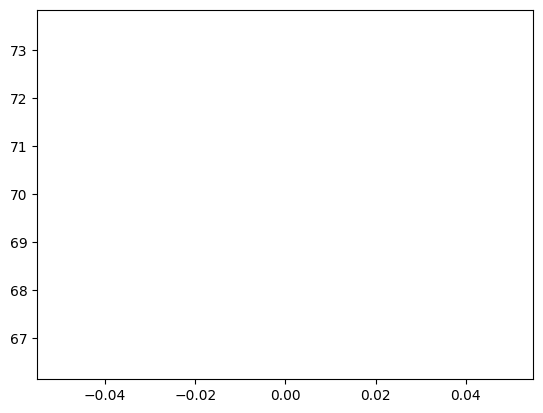

In [7]:
plt.plot(best_model['RNN'][2])

In [9]:
label_y, predicted = predict_mto(best_model['RNN'][1], df, x_ss, y_ms)

88.48202228546143


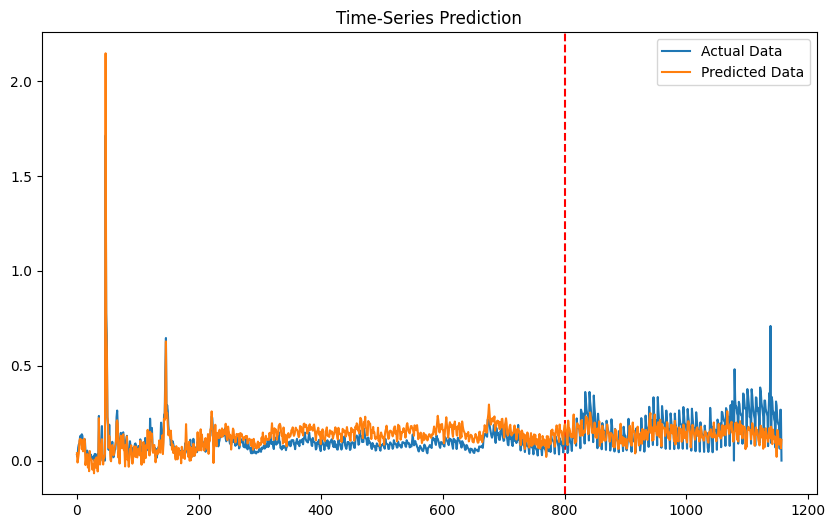

In [10]:
print(mape(label_y+1, predicted))
plotting(label_y, predicted, 800)

In [11]:
data_predicted = data.copy()
data_predicted['predicted_alpha'] = 0
data_predicted.iloc[62:, -1] = predicted
#data_predicted.iloc[63:, -1] = predicted

data_predicted['predicted_Infected'] = data_predicted['Infected']
for i in range(801, len(data_predicted)):
    data_predicted.iloc[i, -1] = (data_predicted.iloc[i-1, -1]
                                  *(1-data_predicted.iloc[i-1, 7] - data_predicted.iloc[i-1, 8]
                                    +(data_predicted.iloc[i-1, 2]*data_predicted.iloc[i-1, 9]
                                      /data_predicted.iloc[0, 2])))
data_predicted

,Date,City,Susceptible,Infected,Dead,Recovered,alpha,beta,gamma,predicted_alpha,predicted_Infected
0,2020-01-20,서울,9535432,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-01-21,서울,9535432,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-01-22,서울,9535432,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-01-23,서울,9535432,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
4,2020-01-24,서울,9535431,1,0,0,0.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
1214,2023-05-20,서울,3372946,63591,6471,6092424,0.186540,0.169175,0.000031,0.084002,1127.060340
1215,2023-05-21,서울,3368750,57027,6473,6103182,0.063087,0.028793,0.000053,0.096959,969.843866
1216,2023-05-22,서울,3367479,56653,6476,6104824,0.268003,0.101407,0.000018,0.113484,975.089152
1217,2023-05-23,서울,3362117,56269,6477,6110569,0.267742,0.099895,0.000036,0.064871,915.270329


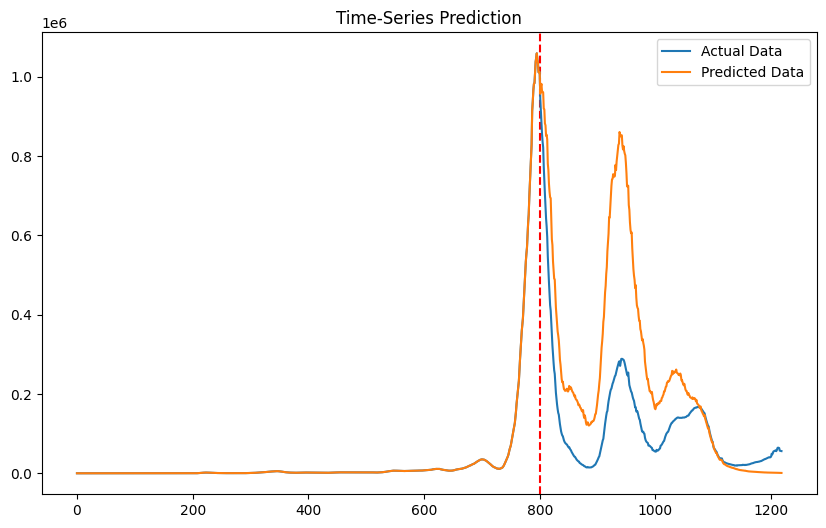

In [13]:
plotting(data_predicted['Infected'], data_predicted['predicted_Infected'], 800)